# **Creación sistema de recomendación de productos cross-selling**
#### Supuestos
1. El presente proyecto ha sido creado, construido y entrenado sobre los clientes y productos incluidos en la muestra dada de 17 millones, misma que no incluye todos los productos dentro del catálogo de productos KOF (24 productos [8%] sin representación) y ni a todos los clientes (733,210 clientes [97%] sin representación).
2. La muestra dada proporciona información de los años 2021 y 2022 por lo que las recomendaciones serán de lo que se habría aconsejado en ese punto en el tiempo.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import networkx as nx
import matplotlib.pyplot as plt
import community
import seaborn as sns
import pickle

## Carga de datos

In [2]:
# read in data
clientes = pd.read_csv('C:/Users/cacho/Downloads/dAT/KOF/data/todas/clientes.csv').drop('Unnamed: 0',axis=1)
productos = pd.read_csv('C:/Users/cacho/Downloads/dAT/KOF/data/todas/codprod.csv').drop('Unnamed: 0',axis=1)
materiales = pd.read_csv('C:/Users/cacho/Downloads/dAT/KOF/data/todas/materiales.csv').drop('Unnamed: 0',axis=1)
ventas = pd.read_csv('C:/Users/cacho/Downloads/dAT/KOF/data/todas/ventas (1).csv.gz').drop('Unnamed: 0',axis=1)

## EDA

#### Clientes

In [3]:
# Describe numerical variables in 'clientes' database
clientes.describe()

,KUNNR,ZZCRMA_LONG,ZZCRMA_LAT,POST_CODE1
count,7.579990e+05,757999.000000,757999.000000,757989.000000
mean,6.053871e+08,-96.181329,18.752674,57031.560122
std,5.561972e+08,15.198204,3.252035,25367.659555
min,1.000000e+08,-114.840778,0.000000,0.000000
25%,1.203307e+08,-99.635937,18.536516,39253.000000
50%,5.051053e+08,-99.036819,19.342837,56567.000000
75%,6.201742e+08,-97.454700,19.716755,75720.000000
max,1.980001e+09,0.000000,42.407211,99999.000000


In [4]:
# Describe categorical variables in 'clientes' database
clientes.describe(include='object')

,BZIRK,STREET,STR_SUPPL3,CITY1,ZCAL_RM1,ZCAL_RM2
count,757999,754881,753694,753996,757999,757999
unique,138,284075,88799,15946,10,19
top,MR0085,CALLE PRINCIPAL,CENTRO,PUEBLA,HM Tradicional,Hogar con Vta.
freq,22201,5586,37923,18687,515796,198813


#### Ventas

In [5]:
# Describe numerical variables in 'ventas' database
ventas.describe()

,KUNNR,MATNR,ANIO,MES,DAY_OF_YEAR,DAY_OF_MONTH,CU,INGRESOBRUTO,VOL_ING_CIMPTOS,CF,MVGR2
count,1.778287e+07,1.778287e+07,1.778287e+07,1.778287e+07,1.778287e+07,1.778287e+07,1.778270e+07,1.778287e+07,1.778287e+07,1.778287e+07,1.763761e+07
mean,1.310573e+09,3.200946e+04,2.021491e+03,6.474154e+00,1.823500e+02,1.666304e+01,4.727209e+00,2.757817e+02,2.004412e+02,2.380222e+00,1.708597e+02
std,3.366708e+07,4.549478e+04,4.999234e-01,3.436116e+00,1.047115e+02,9.158969e+00,3.046794e+01,2.183507e+03,1.842600e+03,2.143519e+01,1.310114e+02
min,1.200952e+08,3.500000e+02,2.021000e+03,1.000000e+00,2.000000e+00,1.000000e+00,-5.706117e+02,-8.679146e+05,-7.892930e+05,-1.800000e+02,1.000000e+02
25%,1.300062e+09,5.130000e+02,2.021000e+03,4.000000e+00,9.100000e+01,9.000000e+00,1.056700e+00,8.840879e+01,6.676313e+01,1.000000e+00,1.000000e+02
50%,1.300234e+09,2.352000e+03,2.021000e+03,6.000000e+00,1.810000e+02,1.700000e+01,2.113400e+00,1.416921e+02,1.029400e+02,1.000000e+00,1.000000e+02
75%,1.320018e+09,9.715300e+04,2.022000e+03,9.000000e+00,2.730000e+02,2.500000e+01,3.170100e+00,2.278623e+02,1.662858e+02,2.000000e+00,1.100000e+02
max,1.520027e+09,1.708370e+05,2.022000e+03,1.200000e+01,3.650000e+02,3.100000e+01,1.493005e+04,1.406617e+06,1.279196e+06,1.204000e+04,9.390000e+02


In [6]:
# Describe categorical variables in 'ventas' database
ventas.describe(include='object')

,KUNNR_MATNR,CALENDAR_DAY,YEAR_MONTH,WEEK_OF_YEAR,DAY_OF_WEEK,RM1,SUBCANAL,TIPO_CANAL,CANAL,CATEGORIA,TIPO_CONSUMO,RETORNABILIDAD,GEC,CLUSTERANALYTICS,BZIRK,RM2,VPTYPT
count,17782874,17782874,17782874,17782874,17782874,17782874,17782874,17782874,17782874,17637609,17637609,17635315,17782874,17782874,17782874,17782874,17782874
unique,1202394,642,24,105,7,10,106,5,22,16,4,2,8,17,1,19,19
top,1360325945-000000000000084134,2022-01-31,2022-01,2022-05,Tuesday,HM Tradicional,MISCELÁNEA,PUNTO DE VENTA TRADICIONAL,COMERCIO DE ABARROTES,COLAS,FAMILIARES (MS),NR,PLATA,LoyalHighPerformers,MR0297,"Abts., Misc. y Minis",Prevendedor
freq,806,283844,889639,416732,3044560,13015629,4707887,13150029,8046265,9571401,8813655,12693891,9220217,7017170,17782874,7851495,13161204


#### Materiales

In [7]:
# Describe numerical variables in 'materiales' database
materiales.describe()

,MATNR,MVGR2
count,7087.000000,7087.000000
mean,75985.698885,343.757867
std,57080.279273,291.335975
min,348.000000,3.000000
25%,2388.500000,110.000000
50%,97854.000000,210.000000
75%,99992.500000,450.000000
max,173167.000000,990.000000


In [8]:
# Describe categorical variables in 'materiales' database
materiales.describe(include='object')

,MAKTX
count,7087
unique,6919
top,NO USAR
freq,12


#### Productos

In [9]:
# Describe numerical variables in 'productos' database
productos.describe()

,MATNR
count,301.000000
mean,66688.312292
std,45155.999766
min,350.000000
25%,2839.000000
50%,97274.000000
75%,99784.000000
max,129498.000000


In [10]:
# Describe categorical variables in 'productos' database
productos.describe(include='object')

,MARCA,TAMANIO,EMPAQUE,LLAVE1
count,301,301,301,301
unique,45,35,7,181
top,CC,20.3 Onz / 600 ML=CC,PET,MUNDET_67.6 Onz / 2 LITROS_PET_NR
freq,35,45,178,8


## Preparación de datos

In [11]:
selected_columns = ventas[['MATNR', 'KUNNR', 'CF', 'CALENDAR_DAY']]
selected_columns['MES'] = pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.to_period('M')

tabla = selected_columns.groupby(['MES', 'KUNNR', 'MATNR'])['CF'].mean().reset_index(name='average_CF_per_month')

def round_to_half(num):
    if num.is_integer():
        return num
    else:
        return round(num * 2) / 2

tabla['average_CF_per_month'] = tabla['average_CF_per_month'].apply(round_to_half)

tabla['total_purchase'] = tabla.groupby(['MES', 'KUNNR'])['MATNR'].transform('count')

monthly_summary = tabla.groupby(['MES', 'KUNNR', 'MATNR']).agg({
    'average_CF_per_month': 'mean',
    'total_purchase': 'sum'
}).reset_index()

monthly_summary

C:\Users\cacho\AppData\Local\Temp\ipykernel_14920\4161538581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['MES'] = pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.to_period('M')


,MES,KUNNR,MATNR,average_CF_per_month,total_purchase
0,2021-01,120095238,353,1.0,28
1,2021-01,120095238,356,0.0,28
2,2021-01,120095238,360,2.5,28
3,2021-01,120095238,376,2.0,28
4,2021-01,120095238,382,1.5,28
...,...,...,...,...,...
7525011,2022-12,1520027293,97151,1.0,11
7525012,2022-12,1520027293,97236,1.0,11
7525013,2022-12,1520027293,97822,1.0,11
7525014,2022-12,1520027293,97839,1.5,11


In [12]:
selected_columns = ventas[['MATNR', 'KUNNR', 'CF', 'CALENDAR_DAY']]
selected_columns['MES'] = pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.year.astype(str) + '-' + pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.month.astype(str).str.zfill(2)

tabla = selected_columns.groupby(['MES', 'KUNNR', 'MATNR'])['CF'].mean().reset_index(name='average_CF_per_month')

def round_to_half(num):
    if num.is_integer():
        return num
    else:
        return round(num * 2) / 2

tabla['average_CF_per_month'] = tabla['average_CF_per_month'].apply(round_to_half)

tabla.head(10)

C:\Users\cacho\AppData\Local\Temp\ipykernel_14920\2565034873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_columns['MES'] = pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.year.astype(str) + '-' + pd.to_datetime(selected_columns['CALENDAR_DAY']).dt.month.astype(str).str.zfill(2)


,MES,KUNNR,MATNR,average_CF_per_month
0,2021-01,120095238,353,1.0
1,2021-01,120095238,356,0.0
2,2021-01,120095238,360,2.5
3,2021-01,120095238,376,2.0
4,2021-01,120095238,382,1.5
5,2021-01,120095238,386,1.0
6,2021-01,120095238,396,1.0
7,2021-01,120095238,445,4.0
8,2021-01,120095238,446,2.0
9,2021-01,120095238,459,2.5


In [13]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale the values in the 'average_CF_per_month' column
tabla['scaled_cf'] = scaler.fit_transform(tabla[['average_CF_per_month']])

# Print the updated DataFrame
print(tabla.head(5))

       MES      KUNNR  MATNR  average_CF_per_month  scaled_cf
0  2021-01  120095238    353                   1.0   0.000913
1  2021-01  120095238    356                   0.0   0.000830
2  2021-01  120095238    360                   2.5   0.001037
3  2021-01  120095238    376                   2.0   0.000996
4  2021-01  120095238    382                   1.5   0.000954


In [14]:
# Define the maximum value
max_value = tabla['scaled_cf'].max()

# Define the number of bins
num_bins = 5

# Generate the bin edges with wider range for lower values
bin_edges = np.concatenate([np.linspace(0, max_value * 0.2, num_bins // 2 + 1, endpoint=False),
                            np.linspace(max_value * 0.2, max_value, num_bins // 2 + 1)])

# Generate the bins for 'scaled_cf'
tabla['scaled_cf_bins'] = pd.cut(tabla['scaled_cf'], bins=bin_edges, labels=False)

# Print the updated DataFrame
tabla.head(5)

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins
0,2021-01,120095238,353,1.0,0.000913,0.0
1,2021-01,120095238,356,0.0,0.000830,0.0
2,2021-01,120095238,360,2.5,0.001037,0.0
3,2021-01,120095238,376,2.0,0.000996,0.0
4,2021-01,120095238,382,1.5,0.000954,0.0


In [15]:
conteo = tabla['MATNR'].value_counts()

# Crear una nueva columna con el conteo
tabla['product_count'] = tabla['MATNR'].map(conteo)

tabla.head(5)

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count
0,2021-01,120095238,353,1.0,0.000913,0.0,126348
1,2021-01,120095238,356,0.0,0.000830,0.0,201859
2,2021-01,120095238,360,2.5,0.001037,0.0,239309
3,2021-01,120095238,376,2.0,0.000996,0.0,43597
4,2021-01,120095238,382,1.5,0.000954,0.0,77323


In [16]:
scaler = MaxAbsScaler()
tabla['product_count_estandarizado'] = scaler.fit_transform(tabla[['product_count']])

tabla.head(5)

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328
3,2021-01,120095238,376,2.0,0.000996,0.0,43597,0.157462
4,2021-01,120095238,382,1.5,0.000954,0.0,77323,0.279272


In [17]:
max_value

1.0

In [18]:
# Count the number of values in each category
count_values = tabla['scaled_cf_bins'].value_counts()

# Print the count values
print(count_values)

0.0    7524696
1.0        171
2.0         74
3.0         69
4.0          5
Name: scaled_cf_bins, dtype: int64


----

## Creación de comunidades

Tanto las comunidades como el grafo de recomendación se crearon con los mismos datos. Lo único es que para que las transformaciones que va teniendo el df para la recomendación no afecte la creación de comunidades, primero se hace la detección de las mismo y luego la recomendación.

In [19]:
# Crear el grafo
G = nx.Graph()

# Agregar los nodos al grafo
G.add_nodes_from(tabla['MATNR'], bipartite=0)
G.add_nodes_from(tabla['KUNNR'], bipartite=1)

# Agregar los bordes al grafo
for row in tabla.itertuples():
    G.add_edge(row.MATNR, row.KUNNR, weight=row.product_count_estandarizado)

In [20]:
# Obtener las comunidades utilizando el algoritmo de Louvain con ponderación negativa
partition = community.best_partition(G, weight='sentiment_kw2')

In [21]:
# Obtener el número total de comunidades
num_communities = len(set(partition.values()))

# Obtener la cantidad de nodos en cada comunidad
node_count_per_community = {}
for node, community_id in partition.items():
    if community_id not in node_count_per_community:
        node_count_per_community[community_id] = 0
    node_count_per_community[community_id] += 1

# Imprimir el número de comunidades y la cantidad de nodos en cada comunidad
print("Número de comunidades:", num_communities)
for community_id, count in node_count_per_community.items():
    print("Comunidad", community_id, "- Cantidad de nodos:", count)

Número de comunidades: 3
Comunidad 2 - Cantidad de nodos: 14301
Comunidad 1 - Cantidad de nodos: 6952
Comunidad 0 - Cantidad de nodos: 4439


In [22]:
# Obtener las comunidades como listas de nodos
comunidades = [[] for _ in range(max(partition.values()) + 1)]
for node, community_id in partition.items():
    comunidades[community_id].append(node)

# Obtener el tamaño de las comunidades
tamano_comunidades = [len(comunidad) for comunidad in comunidades]
tamano_comunidades

[4439, 6952, 14301]

In [23]:
comunidades_map = {}
for i in range(len(comunidades)):
    comunidades_map.update(dict.fromkeys(comunidades[i], i))

In [24]:
# Obtener el número de comunidades
num_comunidades = len(set(comunidades_map.values()))

# Crear una paleta de colores basada en el número de comunidades
color_pallet = sns.color_palette('hls', num_comunidades)

# Crear una lista de colores para los nodos basada en la comunidad a la que pertenecen
color_nodos = [color_pallet[comunidades_map[node]] for node in G]

In [25]:
# Obtener la información de los nodos
nodos = list(G.nodes)
comunidades = [partition[nodo] for nodo in nodos]
nodos_datos = [(nodo, G.nodes[nodo], comunidad) for nodo, comunidad in zip(nodos, comunidades)]

# Crear el dataframe de los nodos
df_nodos = pd.DataFrame(nodos_datos, columns=['nodo', 'datos', 'comunidad'])

In [26]:
with open('community.pickle', 'wb') as file:
    pickle.dump(df_nodos, file)

----

## Creación del grafo

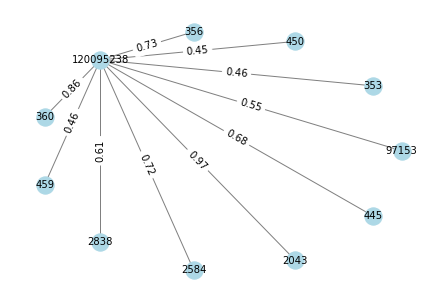

In [27]:
# Crear el grafo
G = nx.Graph()

# Agregar los nodos al grafo
G.add_nodes_from(tabla['MATNR'], bipartite=0)
G.add_nodes_from(tabla['KUNNR'], bipartite=1)

# Agregar los bordes al grafo
for row in tabla.itertuples():
    G.add_edge(row.MATNR, row.KUNNR, weight=row.product_count_estandarizado)

# Definir la función de recomendación
def recomendar_productos(grafo, nodo, num_recomendaciones):
    recomendaciones = []
    
    if nodo in grafo.nodes:
        # Obtener los vecinos del nodo en el grafo original
        vecinos = list(grafo.neighbors(nodo))
        
        # Filtrar los vecinos que no son del tipo 'MATNR'
        vecinos_validos = [vecino for vecino in vecinos if grafo.nodes[vecino]['bipartite'] == 0]
        
        # Ordenar los vecinos según el peso de los bordes en forma descendente
        vecinos_ordenados = sorted(vecinos_validos, key=lambda x: grafo[nodo][x]['weight'], reverse=True)
        
        # Seleccionar el número de recomendaciones solicitado
        recomendaciones = vecinos_ordenados[:num_recomendaciones]
    
    # Crear un subgrafo con los nodos y bordes correspondientes a las recomendaciones
    subgrafo = grafo.subgraph(recomendaciones + [nodo])
    
    return subgrafo

# Ejemplo de uso: obtener el subgrafo de recomendaciones para el nodo 'A' con 2 recomendaciones
subgrafo_recomendaciones = recomendar_productos(G, 120095238, 10)

# Layout de los nodos
pos = nx.circular_layout(subgrafo_recomendaciones)

# Visualizar el subgrafo
nx.draw(subgrafo_recomendaciones, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray', width=1, font_size=10, font_color='black')

# Obtener los pesos de los bordes y redondearlos a dos decimales
edge_labels = {(u, v): f"{weight:.2f}" for (u, v, weight) in subgrafo_recomendaciones.edges.data('weight')}

# Mostrar los pesos de los bordes
nx.draw_networkx_edge_labels(subgrafo_recomendaciones, pos=pos, edge_labels=edge_labels)

plt.show()

----

#### Exportación df recomendación a Plugin

In [28]:
recomendacion_df = pd.DataFrame(list(subgrafo_recomendaciones.edges(data=True)), columns=['Nodo1', 'Nodo2', 'Peso'])
recomendacion_df['Nodo1'] = recomendacion_df['Nodo1'].astype(int)
recomendacion_df['Nodo2'] = recomendacion_df['Nodo2'].astype(int)
recomendacion_df['Peso'] = recomendacion_df['Peso'].apply(lambda x: x['weight'])

In [29]:
with open('recomen.pickle', 'wb') as file:
    pickle.dump(recomendacion_df, file)

----

In [30]:
def extract_edges_info(subgraph, nodo):
    # Obtener los nodos vecinos del nodo objetivo
    vecinos = list(subgraph.neighbors(nodo))
    
    # Crear una lista para almacenar los datos de los bordes
    edges_data = []
    
    # Recorrer los nodos vecinos y obtener los datos de los bordes
    for vecino in vecinos:
        weight = subgraph[nodo][vecino]['weight']
        edges_data.append((nodo, vecino, weight))
    
    # Crear un DataFrame con los datos de los bordes
    df = pd.DataFrame(edges_data, columns=['KUNNR', 'MATNR', 'product_count_estandarizado'])
    
    return df

# Ejemplo de uso
df5 = extract_edges_info(subgrafo_recomendaciones, 120095238)
print(df5)

       KUNNR  MATNR  product_count_estandarizado
0  120095238    353                     0.456339
1  120095238    356                     0.729067
2  120095238    360                     0.864328
3  120095238    445                     0.679647
4  120095238    459                     0.457871
5  120095238   2838                     0.613256
6  120095238  97153                     0.549472
7  120095238    450                     0.453363
8  120095238   2584                     0.718709
9  120095238   2043                     0.973237


In [31]:
# Create the test_modelo DataFrame
test_modelo = df5.copy()
# Add an empty column named "average_CF_per_month"
test_modelo['average_CF_per_month'] = pd.Series()
# Replace values in the "average_CF_per_month" column with 0
test_modelo['average_CF_per_month'].fillna(0, inplace=True)
# Print the updated DataFrame
print(test_modelo)

       KUNNR  MATNR  product_count_estandarizado  average_CF_per_month
0  120095238    353                     0.456339                   0.0
1  120095238    356                     0.729067                   0.0
2  120095238    360                     0.864328                   0.0
3  120095238    445                     0.679647                   0.0
4  120095238    459                     0.457871                   0.0
5  120095238   2838                     0.613256                   0.0
6  120095238  97153                     0.549472                   0.0
7  120095238    450                     0.453363                   0.0
8  120095238   2584                     0.718709                   0.0
9  120095238   2043                     0.973237                   0.0


C:\Users\cacho\AppData\Local\Temp\ipykernel_14920\3425360314.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test_modelo['average_CF_per_month'] = pd.Series()


## Modelos de predicción 

In [32]:
specific_value = 120095238  # Replace with the desired column value

# Select rows with the specific column value
tabla1 = tabla[tabla['KUNNR'] == specific_value]

In [33]:
### Decision Tree Regressor

# Split the dataset into features (X) and target variable (y)
X_train = tabla1[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_train = tabla1['average_CF_per_month']

# Split the test dataset into features (X) and target variable (y)
X_test = test_modelo[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_test = test_modelo['average_CF_per_month']

# Create an instance of the decision tree regressor
model = DecisionTreeRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 4.979605927510752


In [34]:
### Random Forest Regressor

# Split the dataset into features (X) and target variable (y)
X_train = tabla1[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_train = tabla1['average_CF_per_month']

# Split the test dataset into features (X) and target variable (y)
X_test = test_modelo[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_test = test_modelo['average_CF_per_month']

# Create an instance of the Random Forest regressor
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 5.028549862543899


In [35]:
### Random Forest Regressor

# Split the dataset into features (X) and target variable (y)
X_train = tabla1[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_train = tabla1['average_CF_per_month']

# Split the test dataset into features (X) and target variable (y)
X_test = test_modelo[['KUNNR', 'MATNR', 'product_count_estandarizado']]
y_test = test_modelo['average_CF_per_month']

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create an instance of the Random Forest regressor
model = RandomForestRegressor()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test set using the best estimator
y_pred = best_estimator.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 5.467601647559737


A partir de la generación de modelos de predicción y su comparación de acuerdo al MSE, decidimos trabajar con Decision Tree Regressor, ya que tiene un MSE más bajo a comparación de los demás. Con ello, obtuvimos la predicción para trabajar con ella. 

In [36]:
# Create a new DataFrame to store the predictions
predictions_df = test_modelo.copy()

# Add a new column for the predicted values
predictions_df['average_CF_per_month'] = y_pred

predictions_df['average_CF_per_month'] = predictions_df['average_CF_per_month'].apply(round_to_half)

# Print the predictions DataFrame
print(predictions_df) 

       KUNNR  MATNR  product_count_estandarizado  average_CF_per_month
0  120095238    353                     0.456339                   1.0
1  120095238    356                     0.729067                   0.5
2  120095238    360                     0.864328                   3.5
3  120095238    445                     0.679647                   3.5
4  120095238    459                     0.457871                   2.5
5  120095238   2838                     0.613256                   2.0
6  120095238  97153                     0.549472                   1.5
7  120095238    450                     0.453363                   1.5
8  120095238   2584                     0.718709                   2.5
9  120095238   2043                     0.973237                   2.5


## Ajustes de confianza a la predicción

In [37]:
### Buscar MIN y MAX

In [38]:
# Group the DataFrame by KUNNR and MATNR and calculate the overall minimum and maximum values for average_CF_per_month
grouped_df = tabla1.groupby(['KUNNR', 'MATNR'])['average_CF_per_month'].agg(['min', 'max']).reset_index()

# Merge the grouped_df with the original tabla1 DataFrame to add the min and max columns
tabla2 = tabla1.merge(grouped_df, on=['KUNNR', 'MATNR'], how='left')

# Print the updated tabla1 DataFrame
tabla2.head()

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado,min,max
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339,0.5,2.0
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067,0.0,1.0
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328,1.5,6.0
3,2021-01,120095238,376,2.0,0.000996,0.0,43597,0.157462,0.5,4.0
4,2021-01,120095238,382,1.5,0.000954,0.0,77323,0.279272,0.5,2.0


In [39]:
### Mappear este valor al subset de acuerdo al rango de CF

In [40]:
# Create a new column CF_final in predictions_df
predictions_df['CF_final'] = predictions_df['average_CF_per_month']

# Iterate over each row in predictions_df
for index, row in predictions_df.iterrows():
    # Get the corresponding KUNNR and MATNR values
    KUNNR = row['KUNNR']
    MATNR = row['MATNR']
    
    # Find the matching row in tabla2 based on KUNNR and MATNR
    matching_row = tabla2[(tabla2['KUNNR'] == KUNNR) & (tabla2['MATNR'] == MATNR)]
    
    # Get the minimum and maximum values from tabla2
    min_value = matching_row['min'].values[0]
    max_value = matching_row['max'].values[0]
    
    # Check if average_CF_per_month is within the min-max range
    if min_value <= row['average_CF_per_month'] <= max_value:
        # Keep the original value
        predictions_df.at[index, 'CF_final'] = row['average_CF_per_month']
    elif row['average_CF_per_month'] < min_value:
        # Assign the minimum value from tabla2
        predictions_df.at[index, 'CF_final'] = min_value
    else:
        # Assign the maximum value from tabla2
        predictions_df.at[index, 'CF_final'] = max_value

# Print the updated predictions_df DataFrame
predictions_df


,KUNNR,MATNR,product_count_estandarizado,average_CF_per_month,CF_final
0,120095238,353,0.456339,1.0,1.0
1,120095238,356,0.729067,0.5,0.5
2,120095238,360,0.864328,3.5,3.5
3,120095238,445,0.679647,3.5,3.5
4,120095238,459,0.457871,2.5,2.5
5,120095238,2838,0.613256,2.0,2.0
6,120095238,97153,0.549472,1.5,1.5
7,120095238,450,0.453363,1.5,1.5
8,120095238,2584,0.718709,2.5,2.5
9,120095238,2043,0.973237,2.5,0.0


In [41]:
# Merge the 'CF_final' column from predictions_df to tabla2 based on KUNNR and MATNR
tabla3 = tabla2.merge(predictions_df[['KUNNR', 'MATNR', 'CF_final']], on=['KUNNR', 'MATNR'], how='left')

# Print the updated tabla2 DataFrame
tabla3.head()


,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado,min,max,CF_final
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339,0.5,2.0,1.0
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067,0.0,1.0,0.5
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328,1.5,6.0,3.5
3,2021-01,120095238,376,2.0,0.000996,0.0,43597,0.157462,0.5,4.0,NaN
4,2021-01,120095238,382,1.5,0.000954,0.0,77323,0.279272,0.5,2.0,NaN


In [42]:
matnr_values = [353, 356, 360, 445, 459, 2838, 97153, 450, 2584, 2043]  # Specify the desired MATNR values here
filtered_tabla2 = tabla2[tabla2['MATNR'].isin(matnr_values)]

# Merge the CF_final column from predictions_df to filtered_tabla2
filtered_tabla2 = filtered_tabla2.merge(predictions_df[['KUNNR', 'MATNR', 'CF_final']], on=['KUNNR', 'MATNR'], how='left')

# Print the updated filtered_tabla2 DataFrame
filtered_tabla2

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado,min,max,CF_final
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339,0.5,2.0,1.0
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067,0.0,1.0,0.5
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328,1.5,6.0,3.5
3,2021-01,120095238,445,4.0,0.001162,0.0,188176,0.679647,2.0,9.5,3.5
4,2021-01,120095238,459,2.5,0.001037,0.0,126772,0.457871,1.5,8.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...
160,2022-12,120095238,445,9.5,0.001618,0.0,188176,0.679647,2.0,9.5,3.5
161,2022-12,120095238,450,2.0,0.000996,0.0,125524,0.453363,0.5,3.0,1.5
162,2022-12,120095238,459,2.0,0.000996,0.0,126772,0.457871,1.5,8.0,2.5
163,2022-12,120095238,2584,3.5,0.001120,0.0,198991,0.718709,1.0,4.0,2.5


In [43]:
# Crear la columna "diferencia_cf" con la resta al cuadrado
filtered_tabla2['diferencia_cf'] = (filtered_tabla2['average_CF_per_month'] - filtered_tabla2['CF_final'])**2
filtered_tabla2

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado,min,max,CF_final,diferencia_cf
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339,0.5,2.0,1.0,0.00
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067,0.0,1.0,0.5,0.25
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328,1.5,6.0,3.5,1.00
3,2021-01,120095238,445,4.0,0.001162,0.0,188176,0.679647,2.0,9.5,3.5,0.25
4,2021-01,120095238,459,2.5,0.001037,0.0,126772,0.457871,1.5,8.0,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
160,2022-12,120095238,445,9.5,0.001618,0.0,188176,0.679647,2.0,9.5,3.5,36.00
161,2022-12,120095238,450,2.0,0.000996,0.0,125524,0.453363,0.5,3.0,1.5,0.25
162,2022-12,120095238,459,2.0,0.000996,0.0,126772,0.457871,1.5,8.0,2.5,0.25
163,2022-12,120095238,2584,3.5,0.001120,0.0,198991,0.718709,1.0,4.0,2.5,1.00


In [44]:
# Calcular la suma de los valores en CF_final por cada valor único en MATNR
suma_CF_final = filtered_tabla2.groupby('MATNR')['diferencia_cf'].sum()

# Contar el número de veces que aparece cada valor único en MATNR
count_MATNR = filtered_tabla2.groupby('MATNR').size()

# Iterate over the DataFrame rows
for index, row in filtered_tabla2.iterrows():
    matnr = row['MATNR']
    suma_cf = suma_CF_final.loc[matnr]
    count = count_MATNR.loc[matnr]
    
    # Perform the division and assign the result to the "N" column
    filtered_tabla2.at[index, 'New'] = suma_cf / count

# Print the updated DataFrame
filtered_tabla2

,MES,KUNNR,MATNR,average_CF_per_month,scaled_cf,scaled_cf_bins,product_count,product_count_estandarizado,min,max,CF_final,diferencia_cf,New
0,2021-01,120095238,353,1.0,0.000913,0.0,126348,0.456339,0.5,2.0,1.0,0.00,0.156250
1,2021-01,120095238,356,0.0,0.000830,0.0,201859,0.729067,0.0,1.0,0.5,0.25,0.250000
2,2021-01,120095238,360,2.5,0.001037,0.0,239309,0.864328,1.5,6.0,3.5,1.00,1.083333
3,2021-01,120095238,445,4.0,0.001162,0.0,188176,0.679647,2.0,9.5,3.5,0.25,2.458333
4,2021-01,120095238,459,2.5,0.001037,0.0,126772,0.457871,1.5,8.0,2.5,0.00,1.793478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2022-12,120095238,445,9.5,0.001618,0.0,188176,0.679647,2.0,9.5,3.5,36.00,2.458333
161,2022-12,120095238,450,2.0,0.000996,0.0,125524,0.453363,0.5,3.0,1.5,0.25,0.615385
162,2022-12,120095238,459,2.0,0.000996,0.0,126772,0.457871,1.5,8.0,2.5,0.25,1.793478
163,2022-12,120095238,2584,3.5,0.001120,0.0,198991,0.718709,1.0,4.0,2.5,1.00,0.763158


## Predicción final con ajustes de confianza

In [81]:
# Iterate over the DataFrame rows in filtered_tabla2
for index, row in filtered_tabla2.iterrows():
    matnr = row['MATNR']
    new_value = row['New']
    
    # Update 'New' column in predictions_df for matching 'MATNR' values
    predictions_df.loc[predictions_df['MATNR'] == matnr, 'New'] = new_value

# Print the updated predictions_df
predictions_df

,KUNNR,MATNR,product_count_estandarizado,average_CF_per_month,CF_final,New,Closest_product_count_est,Min_average_CF_per_month
0,120095238,353,0.456339,1.0,1.0,0.156250,NaN,NaN
1,120095238,356,0.729067,0.5,0.5,0.250000,NaN,NaN
2,120095238,360,0.864328,3.5,3.5,1.083333,NaN,NaN
3,120095238,445,0.679647,3.5,3.5,2.458333,NaN,NaN
4,120095238,459,0.457871,2.5,2.5,1.793478,NaN,NaN
5,120095238,2838,0.613256,2.0,2.0,0.989583,NaN,NaN
6,120095238,97153,0.549472,1.5,1.5,0.250000,NaN,NaN
7,120095238,450,0.453363,1.5,1.5,0.615385,NaN,NaN
8,120095238,2584,0.718709,2.5,2.5,0.763158,NaN,NaN
9,120095238,2043,0.973237,2.5,0.0,0.000000,NaN,NaN
